In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Função para limpar e preparar os dados
def limpar_df_ipea(df_ipea):
    df_ipea.rename(columns={
        'Data': 'ds',
        'Preço - petróleo bruto - Brent (FOB)': 'y',
    }, inplace=True)

    df_ipea['ds'] = pd.to_datetime(df_ipea['ds'], format='%d/%m/%Y')
    df_ipea['y'] = df_ipea['y'].str.replace(',', '.').astype(float)
    df_ipea.sort_values(by=['ds'], ascending=True, inplace=True)
    df_ipea.set_index('ds', inplace=True)

df_ipea = pd.read_csv('/content/drive/MyDrive/PosTech_Analise_de_dados/FASE4/tech_challenge_4/dados/ipeadata.csv',  encoding='iso-8859-1',  sep=';')
limpar_df_ipea(df_ipea)

In [ ]:
lstm_df_ipea = df_ipea.copy()

In [ ]:
# lstm_df_ipea = lstm_df_ipea[lstm_df_ipea.index >= lstm_df_ipea.index.max() - pd.DateOffset(years=10)]

In [ ]:
#transformar em array
close = lstm_df_ipea['y'].to_numpy().reshape(-1,1)

In [ ]:
# separar 80% para treinamento
train_close= int(len(close)*0.8)
train_close

8950

In [ ]:
# Escalar os dados entre 0 e 1 para processamento
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_train = scaler.fit_transform(close[0: train_close, :])
scaler_test = scaler.transform(close[train_close:,:])

scaled_data = list(scaler_train.reshape(len(scaler_train))) + list(scaler_test.reshape(len(scaler_test)))
scaled_data = np.array(scaled_data).reshape(len(scaled_data),1)
scaled_data

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       ...,
       [0.50812013],
       [0.51182796],
       [0.52272896]])

In [ ]:
# Para o treinamento sera visto 30 dias anteriores
train_data = scaled_data[0: train_close,:]

X_train = []
y_train = []

for i in range(30, len(train_data)):
  X_train.append(train_data[i - 30:i, 0])
  y_train.append(train_data[i, 0])

  if i <= 31:
    print(X_train)
    print(y_train)

[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737,
       0.07378569, 0.07378569, 0.07415647, 0.07267334, 0.07156099,
       0.07119021, 0.07400816, 0.07452725, 0.07400816, 0.07326659])]
[0.07526881720430108]
[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737,
       0.07378569, 0.07378569, 0.07415647, 0.07267334, 0.07156099,
       0.07119021, 0.07400816, 0.07452725, 0.07400816, 0.07326659]), array([0.0693363 , 0.07007786, 0.07044865, 0.07067112, 0.07044865,
       0.07044865, 0.07030033, 0.07081943, 0.0710419 , 0.07156099,
       0.07178346, 0.07081943, 0.0

In [ ]:
# Reformular os dados para o formato 3d
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [ ]:
# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_4 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 18801 (73.44 KB)
Trainable params: 18801 (73.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Treinar o modelo
train_model = model.fit(X_train, y_train, epochs=10, batch_size=30)

Epoch 1/10
298/298 [==============================] - 20s 47ms/step - loss: 0.0036
Epoch 2/10
298/298 [==============================] - 15s 51ms/step - loss: 4.5078e-04
Epoch 3/10
298/298 [==============================] - 15s 49ms/step - loss: 3.5935e-04
Epoch 4/10
298/298 [==============================] - 14s 49ms/step - loss: 2.9754e-04
Epoch 5/10
298/298 [==============================] - 14s 47ms/step - loss: 3.0827e-04
Epoch 6/10
298/298 [==============================] - 13s 45ms/step - loss: 2.5716e-04
Epoch 7/10
298/298 [==============================] - 13s 45ms/step - loss: 2.3041e-04
Epoch 8/10
298/298 [==============================] - 12s 41ms/step - loss: 2.5038e-04
Epoch 9/10
298/298 [==============================] - 12s 41ms/step - loss: 2.3531e-04
Epoch 10/10
298/298 [==============================] - 18s 60ms/step - loss: 2.1678e-04


In [ ]:
test_data = scaled_data[train_close - 30:, :]

X_test = []
y_test = close[train_close:,:]

for i in range(30, len(test_data)):
  X_test.append(test_data[i - 30: i, 0])

In [ ]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Criar a predição
prev_lstm = model.predict(X_test)

# Inverter os dados da predição
prev_lstm = scaler.inverse_transform(prev_lstm)

prev_lstm

70/70 [==============================] - 3s 17ms/step


array([[45.314167],
       [45.29655 ],
       [45.38557 ],
       ...,
       [78.86009 ],
       [77.971436],
       [77.4053  ]], dtype=float32)

In [ ]:
# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, prev_lstm)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, prev_lstm)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, prev_lstm)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_test - prev_lstm) / y_test)) * 100

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}%")

MSE: 8.11
MAE: 1.95
R²: 0.98
MAPE: 3.11%


In [ ]:
train_g = lstm_df_ipea.iloc[: train_close, :]
test_g = pd.DataFrame({"y":lstm_df_ipea['y'].iloc[train_close:],"previsao":prev_lstm.reshape(len(prev_lstm))})

In [ ]:
# Criar a figura
fig = go.Figure()

# Adicionar as séries de dados ao gráfico
fig.add_trace(go.Scatter(x=train_g.index, y=train_g['y'], mode='lines', name='Treinamento'))
fig.add_trace(go.Scatter(x=test_g.index, y=test_g['y'], mode='lines', name='Valor Real'))
fig.add_trace(go.Scatter(x=test_g.index, y=test_g['previsao'], mode='lines', name='Previsão'))

# Atualizar layout do gráfico
fig.update_layout(title='Previsão LSTM ', xaxis_title='Período', yaxis_title='Valor')

# Exibir o gráfico
fig.show()

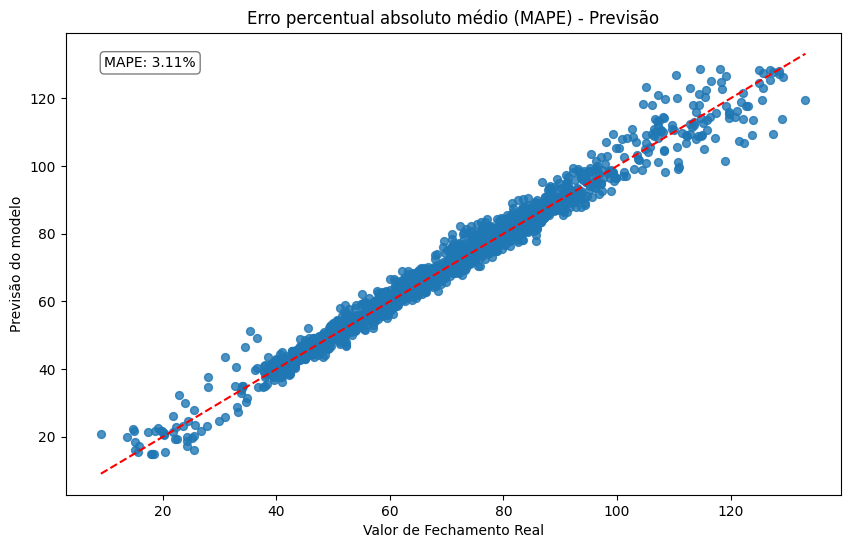

In [ ]:
# Calcular o erro percentual absoluto para cada ponto de dados
test_g['erro_percentual_absoluto'] = np.abs((test_g['y'] - test_g['previsao']) / test_g['y']) * 100

# Calcular o MAPE
mape = test_g['erro_percentual_absoluto'].mean()

# Criar figura
plt.figure(figsize=(10, 6))

# Plotar o gráfico de dispersão
plt.scatter(test_g['y'], test_g['previsao'], s=32, alpha=0.8)

# Adicionar linha diagonal (y=x)
plt.plot([test_g['y'].min(), test_g['y'].max()], [test_g['y'].min(), test_g['y'].max()], color='red', linestyle='--')

# Adicionar texto com o MAPE
plt.text(0.05, 0.95, f'MAPE: {mape:.2f}%', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Configurar o gráfico
plt.xlabel('Valor de Fechamento Real')
plt.ylabel('Previsão do modelo')
plt.title('Erro percentual absoluto médio (MAPE) - Previsão')

# Exibir o gráfico
plt.show()

# Previsão para futuro

In [ ]:
# Definir a data de hoje
today = datetime.now()

# Definir a data inicial para os últimos 30 dias
start_date = today - timedelta(days=30)

last_30_days = close.copy()

# Escalonar os últimos 30 dias de dados de fechamento
last_30_days_scaled = scaler.transform(last_30_days)

# Preparar os dados para a previsão
X_test = np.array([last_30_days_scaled])

# Redimensionar os dados para o formato aceito pelo modelo
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Fazer a predição para os próximos 30 dias
predictions = []
for i in range(30):
    pred_future = model.predict(X_test)
    predictions.append(pred_future)
    # Atualizar X_test para incluir a nova previsão
    X_test = np.append(X_test[:, 1:, :], pred_future.reshape(1, 1, 1), axis=1)

# Inverter a escala das previsões
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

# Imprimir as previsões para os próximos 30 dias
print(predictions)


1/1 [==============================] - 1s 1s/step
[[77.07919 ]
 [77.147995]
 [77.26205 ]
 [77.37678 ]
 [77.48261 ]
 [77.582886]
 [77.68313 ]
 [77.787224]
 [77.89669 ]
 [78.01133 ]
 [78.13003 ]
 [78.25131 ]
 [78.373764]
 [78.49617 ]
 [78.61759 ]
 [78.73729 ]
 [78.85477 ]
 [78.96971 ]
 [79.08198 ]
 [79.19149 ]
 [79.2983  ]
 [79.40252 ]
 [79.504326]
 [79.603905]
 [79.70151 ]
 [79.797356]
 [79.8917  ]
 [79.98479 ]
 [80.07683 ]
 [80.16803 ]]


In [ ]:
ultima_data = lstm_df_ipea.index.max()
proxima_data = ultima_data + pd.Timedelta(days=1)
dates = pd.date_range(start=proxima_data, periods=30, freq='D')

future_predictions_df = pd.DataFrame({'ds': dates, 'previsao': predictions.flatten()})
future_predictions_df.set_index('ds', inplace=True)

In [ ]:
lstm_data = lstm_df_ipea[lstm_df_ipea.index >= lstm_df_ipea.index.max() - pd.DateOffset(years=4)]
future_data = pd.DataFrame(future_predictions_df)

# Mesclar os DataFrames
combined_df = lstm_data.merge(future_data, on='ds', how='outer')

# Plotar o gráfico
fig = go.Figure()

# Adicionar a linha dos valores reais
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['y'], name='Valor Real', line=dict(color='steelblue')))

# Adicionar a linha das previsões
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['previsao'], name='Previsão', line=dict(color='orange')))

# Layout do gráfico
fig.update_layout(
    title='Previsão LSTM vs Valores Reais',
    xaxis_title='Data',
    yaxis_title='Valor',
    legend_title='Tipo',
    template='plotly_white'
)

# Mostrar o gráfico
fig.show()

In [ ]:
today = datetime.now()

today = datetime.now() - timedelta(days=1)

if today.hour > 24:
  final = today
  start = datetime.now() - timedelta(days=30)

last_30_days = close.copy()

last_30_days_scaler = scaler.transform(last_30_days)

X_test = []
X_test.append(last_30_days_scaler)
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Criar a predição
prev_future = model.predict(X_test)

# Inverter os dados da predição
prev_future = scaler.inverse_transform(prev_future)

print(prev_future)

1/1 [==============================] - 1s 1s/step
[[77.07919]]
